In [1]:
import os
import numpy as np
import scipy as sc
import sys
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
import time
import datetime
import matplotlib.pyplot as plt
import math as m
from sklearn import mixture
from scipy.optimize import minimize
from sklearn.datasets import make_moons
import utils as utl
from custom_bijectors import GMC_bijector, mv_GMM_icdf_bijector
sys.path.append('C:/Users/tewar/Documents/work/BNAF-master/data/')
%load_ext tensorboard

Number of samples = 315123, Number of dimensions = 21


[<tf.Tensor: shape=(21,), dtype=float64, numpy=
 array([-2.27539969, -2.54184485, -1.74444188, -8.06296516, -1.7412063 ,
        -5.19342209, -3.0593629 , -1.74016727, -4.14482714, -2.74720622,
        -1.7414322 , -3.16284705, -2.53237415, -1.74216414, -2.01021672,
        -2.3120041 , -1.74223102, -3.08088447, -3.42451955, -5.93790604,
        -2.53128077])>,
 <tf.Tensor: shape=(21,), dtype=float64, numpy=
 array([3.39583231, 2.53894449, 1.73964811, 2.76432873, 1.74018551,
        4.70487762, 3.05755569, 1.74098946, 4.55801416, 2.74939061,
        1.74314476, 4.40146709, 2.53241302, 1.74014259, 4.31953074,
        2.3091302 , 1.74290682, 5.89488817, 7.44147755, 9.96665741,
        4.09884811])>]

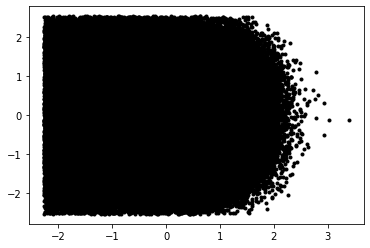

In [3]:
# # Generating the samples from 2 moons
# observations = tf.constant(make_moons(150000, noise=0.1)[0].astype("float64"))

# from gas import GAS
# gg=GAS('C:/Users/tewar/Documents/work/GMCM/data/gas/ethylene_CO.pickle')
# observations = tf.constant(gg.trn.x,dtype=tf.float64)
# dataset_name= 'GAS' 

# from power import POWER
# gg=POWER('C:/Users/tewar/Documents/work/GMCM/data/power/data.npy')
# observations = tf.constant(gg.trn.x,dtype=tf.float64)
# dataset_name = 'POWER'

from hepmass import HEPMASS
gg=HEPMASS('C:/Users/tewar/Documents/work/GMCM/data/hepmass/')
observations = tf.constant(gg.trn.x,dtype=tf.float64)
dataset_name, LR = ['HEPMASS', 1E-3]

# from miniboone import MINIBOONE
# gg=MINIBOONE('C:/Users/tewar/Documents/work/GMCM/data/miniboone/data.npy')
# observations = tf.constant(gg.trn.x,dtype=tf.float64)
# dataset_name = 'MINIBOONE'

# from bsds300 import BSDS300
# gg=BSDS300('C:/Users/tewar/Documents/work/GMCM/data/bsds300/BSDS300.hdf5')
# observations = tf.constant(gg.trn.x,dtype=tf.float64)
# dataset_name = 'BSDS300'

nsamps,ndims = observations.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

# noting the dimension wise bounds
dimension_wise_bounds = [tf.reduce_min(observations,axis=0)-0.01  , tf.reduce_max(observations,axis=0) + 0.01]
u_all,_ = utl.fitMargNonParam(observations)

np.random.seed(30)
idx_selected = np.unique(np.random.randint(0,nsamps,int(nsamps/1)))
observations = tf.gather(observations,idx_selected,axis=0)
u_all = tf.gather(u_all,idx_selected,axis=0)

plt.plot(observations[:,0],observations[:,1],'k.')

dimension_wise_bounds


In [4]:
# Specifying the sizes of training, test and validation datasets
n_train = int(0.70*np.shape(observations)[0])
n_valid = int(0.15*np.shape(observations)[0])
n_test = np.shape(observations)[0]-(n_train+n_valid)
x_train,x_valid,x_test = tf.split(observations,[n_train,n_valid,n_test])

print(f'Number of training samples = {n_train}')
print(f'Number of validation samples = {n_valid}')
print(f'Number of test samples = {n_test}')

Number of training samples = 139346
Number of validation samples = 29860
Number of test samples = 29861


In [5]:
# Fitting the Gaussian distribution
mu_v = tf.reduce_mean(x_train,axis=0)
cov_m = np.cov(x_train.numpy(),rowvar=False)
chol_m = tf.linalg.cholesky(cov_m)
gauss_dist =tfd.MultivariateNormalTriL(loc=mu_v,scale_tril=chol_m)
mean_logL_Gaussian = tf.reduce_mean(gauss_dist.log_prob(x_valid))
print(f'The mean out-of-sample log-likelihood is = {mean_logL_Gaussian}')

The mean out-of-sample log-likelihood is = -27.920736202199006


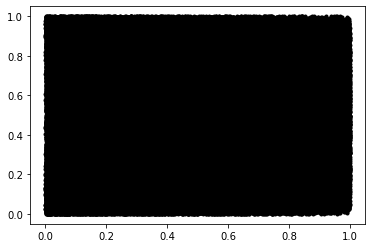

In [6]:
# Learning the marginal distribution first as a mixture of Gaussians distribution and outputting the marginal CDF values and vectorized marginal params
_,marg_params = utl.fitMargGMMs(observations,dimension_wise_bounds,ncomps=20)
# Splitting the data in train,validation and test
u_train,u_valid,u_test = tf.split(u_all,[n_train,n_valid,n_test])

nsamps,ndims=np.shape(u_train)
n_marg_params = int(marg_params.shape.as_list()[0])
plt.plot(u_train[:,0],u_train[:,1],'k.')

In [ ]:
# GMC neg-LogLikelihood unregulatized
@tf.function
def neg_logLikelihood_gmc(theta,obs_data):
    # Defining the gmc distribution
    gmc_distribution = utl.vec2gmc_dist(theta,ndims,ncomps)
    return  -tf.reduce_sum(gmc_distribution.log_prob(obs_data)) 
    

# Defining a function that returns the negative log-posterior and its gradients at a specified point (to be used in scipy.optimize.minimize  function)
def val_grad_func_gmc(theta,u_mat):
    negLL_gmc = lambda th: neg_logLikelihood_gmc(th,u_mat)
    f,g = tfp.math.value_and_gradient(negLL_gmc,tf.constant(theta)) # obtaiing the gradient using the  inbuilt function "value_and_gradient"
    g = tf.reshape(g,(tf.size(theta),))
    f = f.numpy().astype('float64') # conversion to float64 is necessary for scipy.minimize to work
    g = g.numpy().astype('float64') # conversion to float64 is necessary for scipy.minimize to work
    return f, g 


In [ ]:
@tf.function
def neg_logLikelihood_gmcm(theta_gmc,theta_marg,bounds,obs_data,reg_param=0.):
    # Defining the gmcm distribution
    gmcm_distribution = utl.param2gmcm_dist(theta_gmc,theta_marg,bounds,ndims,ncomps)
    return  -tf.reduce_sum(gmcm_distribution.log_prob(obs_data)) + 0*reg_param*tf.pow(tf.norm(utl.identifiabilityTransfrom(theta_gmc,ndims,ncomps)),2)

# Defining a function that returns the negative log-posterior and its gradients at a specified point (to be used in scipy.optimize.minimize  function)
def val_grad_func_gmcm(theta_gmc,theta_marg,bounds,obs_data,reg_param):
    negLL_gmcm = lambda th: neg_logLikelihood_gmcm(th,theta_marg,bounds,obs_data,reg_param)
    f,g = tfp.math.value_and_gradient(negLL_gmcm,tf.constant(theta_gmc)) # obtaiing the gradient using the  inbuilt function "value_and_gradient"
    g = tf.reshape(g,(tf.size(theta_gmc),))
    f = f.numpy().astype('float64') # conversion to float64 is necessary for scipy.minimize to work
    g = g.numpy().astype('float64') # conversion to float64 is necessary for scipy.minimize to work
    return f, g 

In [7]:
## Fitting the whole GMCM
# Specifying the number of dimensions and number of components to fit
ncomps = 30
# Initialize parameters of GMC distribution
np.random.seed(30)
theta_init_gmc =  utl.initGMCParams(x_train.numpy(),ndims,ncomps,method='gmm')
theta_init_gmc = tf.constant(theta_init_gmc,dtype=tf.float64)

In [ ]:
## Fitting the only the GMC while the marginals are fixed

## defining a callback function to show progress
def callbackF(th):
    neg_ll,_ = val_grad_func_gmcm(th,marg_params,dimension_wise_bounds,x_valid,0)
    print(neg_ll/n_valid)
    
# Performing the optimization using Scipy Optimization library
start_time = time.time()
optim_results=minimize(val_grad_func_gmc,theta_init_gmc,args=(u_train,),method='L-BFGS-B',jac=True, options={"disp":True,"maxiter":500}, callback=callbackF)
end_time = time.time()

theta_final_gmc = optim_results.x

# Printing various information about the optimizer
print('Time taken to obtain MAP using L-BFGS method: ' + str(np.round(end_time-start_time,decimals=2)) + ' s')
print('Total Iterations: ' + str(optim_results.nit))
print('Total Function Evals: ' + str(optim_results.nfev))
print('Converged: ' + str(optim_results.success))
print('fval at MAP: ' + str(optim_results.fun))


# # Getting the likelihood of the GMCM
# theta_final_gmcm = tf.concat([marg_params,theta_final_gmc],axis=0)
gmcm_dist_final = utl.param2gmcm_dist(theta_final_gmc,marg_params,dimension_wise_bounds,ndims,ncomps)
# gmcm1_log_like = tf.reduce_mean(gmcm_dist_final.log_prob(observations))
# print(f'The log-likelihood of data w.r.t to GMCM(with marginals fixed) is: {gmcm1_log_like}')

In [ ]:
## Plotting the samples from fitted distribution
# generating samples
ss =gmcm_dist_final.sample(20000)
# plotting samples
plt.subplot(121)
plt.plot(ss.numpy()[:,10],ss.numpy()[:,12],'k.')
plt.subplot(122)
plt.plot(observations.numpy()[:,10],observations.numpy()[:,12],'r.')

In [ ]:
plt.hist(ss.numpy()[:,10],20)

In [8]:
# Defining a function that returns the negative log-posterior and its gradients at a specified point (to be used in scipy.optimize.minimize  function)
@tf.function
def gmc_neg_LL_batch(theta_gmc,obs_mat,minibatch_ratio=1.,itr=0.):
    reg_wt = tf.math.exp(-0.003*tf.cast(itr,tf.float64))
    gmc_distribution = utl.vec2gmc_dist(theta_gmc,ndims,ncomps)
    fout =  -(1/minibatch_ratio)*tf.reduce_sum(gmc_distribution.log_prob(obs_mat)) + 0*(1/reg_wt)*tf.pow(tf.norm(utl.identifiabilityTransfrom(theta_gmc,ndims,ncomps)),2)
    return fout

In [9]:
## Starting TensorBoard
# Clear any logs from previous runs
# rm -rf /.logs/
LR='minus3'
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
parent_dir =  'logs/'+dataset_name+'/'+'LR'+str(LR)+'_NComps'+str(ncomps)
train_log_dir = parent_dir + '/learning/train'
valid_log_dir = parent_dir + '/learning/valid'
checkpoint_dir = 'C:/Users/tewar/Documents/work/GMCM/' + parent_dir +'/chkpt'
os.makedirs(checkpoint_dir) 
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
valid_summary_writer = tf.summary.create_file_writer(valid_log_dir)
# %tensorboard  --port=6008 --logdir logs/GAS/LRminus3_NComps60/learning

In [10]:
optimizer = tf.optimizers.Adam(learning_rate=1E-3)
theta_v = tf.Variable(theta_init_gmc)
nsamps,ndims = x_train.shape.as_list()
minibatch_size = 100
minibatch_ratio = (minibatch_size/nsamps)

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
valid_loss = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)

def train_step(itr=0.):
    idx_selected = tf.random.uniform(shape=[minibatch_size],minval=0,maxval=nsamps,dtype=tf.int64)
    u_selected = tf.gather(u_train,idx_selected,axis=0)
    with tf.GradientTape() as tape:
        tape.watch(theta_v)
        neg_ll = gmc_neg_LL_batch(theta_v,u_selected,minibatch_ratio,itr)
    grad = tape.gradient(neg_ll,theta_v)
    optimizer.apply_gradients(zip([grad],[theta_v]))
    return neg_ll, grad

@tf.function
def checkpoint_train_error():
    nsamps_trn,ndims = x_train.shape.as_list()
    idx_selected = tf.random.uniform(shape=[minibatch_size],minval=0,maxval=nsamps_trn,dtype=tf.int64)
    x_selected = tf.gather(x_train,idx_selected,axis=0)
    gmcm_dist = utl.param2gmcm_dist(theta_v,marg_params,dimension_wise_bounds,ndims,ncomps)
    train_loss(gmcm_dist.log_prob(x_selected))

@tf.function    
def checkpoint_valid_error():
    nsamps_vld,ndims = x_valid.shape.as_list()
    idx_selected = tf.random.uniform(shape=[minibatch_size],minval=0,maxval=nsamps_vld,dtype=tf.int64)
    x_selected = tf.gather(x_valid,idx_selected,axis=0)
    gmcm_dist = utl.param2gmcm_dist(theta_v,marg_params,dimension_wise_bounds,ndims,ncomps)
    valid_loss(gmcm_dist.log_prob(x_selected))
    
def checkpoint_save(itr):
    np.save(checkpoint_dir+'/iter'+str(itr),theta_v.numpy())


        

In [11]:
# Running the ADAM optimizer for the specified number of iterations
max_iters = 60000
for itr in range(max_iters):
    if tf.equal(itr%50,0) or tf.equal(itr,0):
        checkpoint_train_error()
        checkpoint_valid_error()
        checkpoint_save(itr)
        print(f'@ Iter= {itr}: Training error = {train_loss.result().numpy()}, Validation error = {valid_loss.result().numpy()}')        
        with valid_summary_writer.as_default():
            tf.summary.scalar('loss', valid_loss.result(), step=itr)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=itr)
    train_step(0)

    
    # resetting states    
    train_loss.reset_states()
    valid_loss.reset_states()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
@ Iter= 0: Training error = -23.250072479248047, Validation error = -23.355674743652344
@ Iter= 50: Training error = -23.05908203125, Validation error = -23.224851608276367
@ Iter= 100: Training error = -22.956789016723633, Validation error = -22.887582778930664
@ Iter= 150: Training error = -22.95738983154297, Validation error = -23.281442642211914
@ Iter= 200: Training error = -22.647001266479492, Validation error = -22.926490783691406
@ Iter= 250: Training error = -23.010974884033203, Validation error = -23.281845092773438
@ Iter= 300: Training error = -22.511341094970703, Validation error = -22.66293716430664
@ Iter= 350: Training error = -23.412948608398438, Validation error = -23.456192016601562
@ Iter= 400: Training error = -22.263498306274414, Validation error = -22.645875930786133
@ Iter= 450: Training error = -23.250268936157227, Validation error = -22.796527862548828
@ Iter= 500: Training 

@ Iter= 4350: Training error = -22.539892196655273, Validation error = -21.177309036254883
@ Iter= 4400: Training error = -22.8996639251709, Validation error = -22.149276733398438
@ Iter= 4450: Training error = -22.042951583862305, Validation error = -21.44562530517578
@ Iter= 4500: Training error = -22.753454208374023, Validation error = -22.185571670532227
@ Iter= 4550: Training error = -22.45110321044922, Validation error = -22.27782440185547
@ Iter= 4600: Training error = -22.542957305908203, Validation error = -21.286592483520508
@ Iter= 4650: Training error = -22.737348556518555, Validation error = -22.821857452392578
@ Iter= 4700: Training error = -23.019672393798828, Validation error = -20.853137969970703
@ Iter= 4750: Training error = -21.861841201782227, Validation error = -21.466672897338867
@ Iter= 4800: Training error = -21.474931716918945, Validation error = -22.750123977661133
@ Iter= 4850: Training error = -22.533187866210938, Validation error = -21.625717163085938
@ It

@ Iter= 8900: Training error = -22.12775421142578, Validation error = -21.8232364654541
@ Iter= 8950: Training error = -21.58777618408203, Validation error = -22.055946350097656
@ Iter= 9000: Training error = -22.444398880004883, Validation error = -21.818513870239258
@ Iter= 9050: Training error = -21.4105281829834, Validation error = -21.532934188842773
@ Iter= 9100: Training error = -21.978620529174805, Validation error = -22.311738967895508
@ Iter= 9150: Training error = -23.226091384887695, Validation error = -21.329059600830078
@ Iter= 9200: Training error = -21.726274490356445, Validation error = -21.979761123657227
@ Iter= 9250: Training error = -21.77838897705078, Validation error = -21.803213119506836
@ Iter= 9300: Training error = -22.15740966796875, Validation error = -21.77452850341797
@ Iter= 9350: Training error = -22.537084579467773, Validation error = -21.650510787963867
@ Iter= 9400: Training error = -20.87502670288086, Validation error = -21.871912002563477
@ Iter= 9

@ Iter= 13400: Training error = -22.460346221923828, Validation error = -22.2124080657959
@ Iter= 13450: Training error = -21.053064346313477, Validation error = -21.248327255249023
@ Iter= 13500: Training error = -21.383991241455078, Validation error = -21.469297409057617
@ Iter= 13550: Training error = -21.82553482055664, Validation error = -21.815528869628906
@ Iter= 13600: Training error = -21.168010711669922, Validation error = -21.78921890258789
@ Iter= 13650: Training error = -21.670896530151367, Validation error = -22.303800582885742
@ Iter= 13700: Training error = -21.268186569213867, Validation error = -22.486967086791992
@ Iter= 13750: Training error = -21.501445770263672, Validation error = -22.603675842285156
@ Iter= 13800: Training error = -21.562152862548828, Validation error = -21.481006622314453
@ Iter= 13850: Training error = -21.255483627319336, Validation error = -22.15555191040039
@ Iter= 13900: Training error = -21.89496421813965, Validation error = -22.3364238739

@ Iter= 17900: Training error = -21.74781036376953, Validation error = -21.522764205932617
@ Iter= 17950: Training error = -21.186805725097656, Validation error = -21.642019271850586
@ Iter= 18000: Training error = -21.4099178314209, Validation error = -20.789709091186523
@ Iter= 18050: Training error = -22.404125213623047, Validation error = -22.1090030670166
@ Iter= 18100: Training error = -21.794940948486328, Validation error = -22.053041458129883
@ Iter= 18150: Training error = -21.2298641204834, Validation error = -21.94122886657715
@ Iter= 18200: Training error = -21.140138626098633, Validation error = -21.904529571533203
@ Iter= 18250: Training error = -22.136619567871094, Validation error = -21.669755935668945
@ Iter= 18300: Training error = -21.939781188964844, Validation error = -21.339427947998047
@ Iter= 18350: Training error = -21.50283432006836, Validation error = -22.461498260498047
@ Iter= 18400: Training error = -21.765914916992188, Validation error = -22.2007617950439

@ Iter= 22400: Training error = -21.69713592529297, Validation error = -22.146778106689453
@ Iter= 22450: Training error = -21.173564910888672, Validation error = -21.889198303222656
@ Iter= 22500: Training error = -21.81928253173828, Validation error = -22.199260711669922
@ Iter= 22550: Training error = -21.521390914916992, Validation error = -21.293596267700195
@ Iter= 22600: Training error = -22.236560821533203, Validation error = -21.198375701904297
@ Iter= 22650: Training error = -21.937646865844727, Validation error = -21.658920288085938
@ Iter= 22700: Training error = -21.51158905029297, Validation error = -21.608930587768555
@ Iter= 22750: Training error = -22.376914978027344, Validation error = -21.705276489257812
@ Iter= 22800: Training error = -22.072179794311523, Validation error = -21.177194595336914
@ Iter= 22850: Training error = -22.392545700073242, Validation error = -20.948902130126953
@ Iter= 22900: Training error = -22.764053344726562, Validation error = -21.5215301

@ Iter= 26900: Training error = -21.510242462158203, Validation error = -21.562885284423828
@ Iter= 26950: Training error = -21.97161293029785, Validation error = -22.154918670654297
@ Iter= 27000: Training error = -22.077075958251953, Validation error = -21.42156410217285
@ Iter= 27050: Training error = -21.79046058654785, Validation error = -22.451580047607422
@ Iter= 27100: Training error = -21.07297134399414, Validation error = -21.552528381347656
@ Iter= 27150: Training error = -21.328018188476562, Validation error = -22.201993942260742
@ Iter= 27200: Training error = -22.144426345825195, Validation error = -20.981752395629883
@ Iter= 27250: Training error = -21.169736862182617, Validation error = -22.0699462890625
@ Iter= 27300: Training error = -21.932655334472656, Validation error = -21.052169799804688
@ Iter= 27350: Training error = -22.024089813232422, Validation error = -21.409626007080078
@ Iter= 27400: Training error = -22.012683868408203, Validation error = -22.2508373260

@ Iter= 31400: Training error = -21.261980056762695, Validation error = -21.9792537689209
@ Iter= 31450: Training error = -20.799659729003906, Validation error = -21.697603225708008
@ Iter= 31500: Training error = -22.144325256347656, Validation error = -21.062232971191406
@ Iter= 31550: Training error = -21.05520248413086, Validation error = -20.96692657470703
@ Iter= 31600: Training error = -21.077045440673828, Validation error = -22.097272872924805
@ Iter= 31650: Training error = -21.406179428100586, Validation error = -22.303056716918945
@ Iter= 31700: Training error = -22.03338050842285, Validation error = -21.219886779785156
@ Iter= 31750: Training error = -22.166711807250977, Validation error = -21.736745834350586
@ Iter= 31800: Training error = -22.477554321289062, Validation error = -21.79688262939453
@ Iter= 31850: Training error = -21.67080307006836, Validation error = -21.228076934814453
@ Iter= 31900: Training error = -21.317211151123047, Validation error = -21.59425544738

@ Iter= 35900: Training error = -22.615339279174805, Validation error = -21.780603408813477
@ Iter= 35950: Training error = -21.320898056030273, Validation error = -21.87531089782715
@ Iter= 36000: Training error = -21.763164520263672, Validation error = -21.451223373413086
@ Iter= 36050: Training error = -21.5876407623291, Validation error = -21.75716781616211
@ Iter= 36100: Training error = -21.841218948364258, Validation error = -21.275354385375977
@ Iter= 36150: Training error = -22.385080337524414, Validation error = -21.08942413330078
@ Iter= 36200: Training error = -21.686418533325195, Validation error = -21.7919864654541
@ Iter= 36250: Training error = -21.9019832611084, Validation error = -21.702594757080078
@ Iter= 36300: Training error = -21.486244201660156, Validation error = -22.166215896606445
@ Iter= 36350: Training error = -20.773849487304688, Validation error = -21.559982299804688
@ Iter= 36400: Training error = -21.609296798706055, Validation error = -21.8650875091552

@ Iter= 40400: Training error = -22.163000106811523, Validation error = -21.128496170043945
@ Iter= 40450: Training error = -20.77072525024414, Validation error = -22.08441734313965
@ Iter= 40500: Training error = -21.605297088623047, Validation error = -22.445175170898438
@ Iter= 40550: Training error = -21.81591796875, Validation error = -21.78008270263672
@ Iter= 40600: Training error = -21.322797775268555, Validation error = -21.021747589111328
@ Iter= 40650: Training error = -20.62639617919922, Validation error = -21.173908233642578
@ Iter= 40700: Training error = -21.798254013061523, Validation error = -21.818445205688477
@ Iter= 40750: Training error = -21.804157257080078, Validation error = -22.333446502685547
@ Iter= 40800: Training error = -21.228477478027344, Validation error = -21.46221351623535
@ Iter= 40850: Training error = -21.252214431762695, Validation error = -22.733091354370117
@ Iter= 40900: Training error = -21.512418746948242, Validation error = -21.6789798736572

@ Iter= 44900: Training error = -21.229965209960938, Validation error = -21.501768112182617
@ Iter= 44950: Training error = -21.064481735229492, Validation error = -20.859973907470703
@ Iter= 45000: Training error = -21.497861862182617, Validation error = -21.751768112182617
@ Iter= 45050: Training error = -21.062910079956055, Validation error = -22.217784881591797
@ Iter= 45100: Training error = -22.31415557861328, Validation error = -21.972139358520508
@ Iter= 45150: Training error = -21.041597366333008, Validation error = -22.113475799560547
@ Iter= 45200: Training error = -22.247455596923828, Validation error = -22.175273895263672
@ Iter= 45250: Training error = -21.296812057495117, Validation error = -21.770893096923828
@ Iter= 45300: Training error = -21.84063720703125, Validation error = -21.72698974609375
@ Iter= 45350: Training error = -21.62286949157715, Validation error = -21.881454467773438
@ Iter= 45400: Training error = -21.866758346557617, Validation error = -21.34116744

@ Iter= 49400: Training error = -21.361841201782227, Validation error = -21.399991989135742
@ Iter= 49450: Training error = -21.58465003967285, Validation error = -21.477123260498047
@ Iter= 49500: Training error = -21.45635986328125, Validation error = -21.810741424560547
@ Iter= 49550: Training error = -21.2823543548584, Validation error = -21.754514694213867
@ Iter= 49600: Training error = -21.89874839782715, Validation error = -22.19867706298828
@ Iter= 49650: Training error = -22.301441192626953, Validation error = -21.9211368560791
@ Iter= 49700: Training error = -21.271718978881836, Validation error = -22.013843536376953
@ Iter= 49750: Training error = -21.724042892456055, Validation error = -21.591951370239258
@ Iter= 49800: Training error = -22.107877731323242, Validation error = -21.78281021118164
@ Iter= 49850: Training error = -21.493144989013672, Validation error = -22.331579208374023
@ Iter= 49900: Training error = -21.274534225463867, Validation error = -22.1116447448730

@ Iter= 53900: Training error = -22.025989532470703, Validation error = -21.43048667907715
@ Iter= 53950: Training error = -21.040916442871094, Validation error = -22.060293197631836
@ Iter= 54000: Training error = -22.173818588256836, Validation error = -22.29717445373535
@ Iter= 54050: Training error = -21.612302780151367, Validation error = -21.590646743774414
@ Iter= 54100: Training error = -21.529787063598633, Validation error = -21.410913467407227
@ Iter= 54150: Training error = -21.663984298706055, Validation error = -21.90204429626465
@ Iter= 54200: Training error = -21.863065719604492, Validation error = -21.722436904907227
@ Iter= 54250: Training error = -21.229604721069336, Validation error = -21.573755264282227
@ Iter= 54300: Training error = -21.086536407470703, Validation error = -22.0760440826416
@ Iter= 54350: Training error = -22.13345718383789, Validation error = -22.387311935424805
@ Iter= 54400: Training error = -22.174518585205078, Validation error = -21.9338264465

@ Iter= 58400: Training error = -21.144577026367188, Validation error = -21.508651733398438
@ Iter= 58450: Training error = -20.86138916015625, Validation error = -21.004262924194336
@ Iter= 58500: Training error = -21.609251022338867, Validation error = -22.368179321289062
@ Iter= 58550: Training error = -21.110275268554688, Validation error = -21.29474449157715
@ Iter= 58600: Training error = -21.885414123535156, Validation error = -21.63930892944336
@ Iter= 58650: Training error = -21.342496871948242, Validation error = -22.30361557006836
@ Iter= 58700: Training error = -22.08832359313965, Validation error = -21.131519317626953
@ Iter= 58750: Training error = -21.256132125854492, Validation error = -21.93172836303711
@ Iter= 58800: Training error = -21.646238327026367, Validation error = -21.25985336303711
@ Iter= 58850: Training error = -21.1789493560791, Validation error = -21.825363159179688
@ Iter= 58900: Training error = -21.647226333618164, Validation error = -21.1614379882812

In [ ]:
# ts = time.time()
# train_step()
# print(time.time()-ts)

# ts = time.time()
# checkpoint_train_error()
# print(time.time()-ts)

# ts = time.time()
# checkpoint_valid_error()
# print(time.time()-ts)
gmcm_dist = utl.param2gmcm_dist(theta_v,marg_params,dimension_wise_bounds,ndims,ncomps)# ss = gmcm_dist.sample(10000)
# plt.hist(ss.numpy()[:,6],100)
ll = gmcm_dist.log_prob(x_valid)

In [ ]:
plt.hist(ll.numpy(),30)

In [ ]:
np.median(ll.numpy())
# utl.identifiabilityTransfrom(theta_v,ndims,ncomps)

In [ ]:
n_selected = 100
minibatch_ratio=n_selected/nsamps
idx_selected = tf.random.uniform(shape=[n_selected],minval=0,maxval=nsamps,dtype=tf.int64)
x_selected = tf.gather(x_train,idx_selected,axis=0)
myfunc = lambda theta_gmc:  gmcm_neg_LL_batch(theta_gmc,marg_params,x_selected,minibatch_ratio,itr=0.)
ts = time.time()
ff,gg = tfp.math.value_and_gradient(myfunc,theta_init_gmc)
print(time.time()-ts)

In [ ]:
minibatch_ratio=0.002
n_selected = int(minibatch_ratio*nsamps)
idx_selected = tf.random.uniform(shape=[n_selected],minval=0,maxval=nsamps,dtype=tf.int64)
u_selected = tf.gather(u_train,idx_selected,axis=0)
myfunc = lambda theta_gmc: neg_logLikelihood_gmc(theta_gmc,u_selected)
ts = time.time()
ff,gg = tfp.math.value_and_gradient(myfunc,theta_init_gmc)
print(time.time()-ts)


In [ ]:
theta_v

In [ ]:
ts = time.time()
with tf.GradientTape() as tape:
    tape.watch(theta_v)
    neg_ll = reg_gmc_neg_LL_batch(theta_v,u_train,100)
grad = tape.gradient(neg_ll,theta_v)
print(time.time()-ts)

ts = time.time()
optimizer.apply_gradients(zip([grad],[theta_v]))
print(time.time()-ts)

ts = time.time()
neg_logLikelihood_gmc(theta_v,u_valid)
print(time.time()-ts)

In [ ]:
plt.plot(x_train[:,0],x_train[:,1],'k.')
plt.plot(x_valid[:,0],x_valid[:,1],'r.')

In [ ]:
# Getting the likelihood of the GMCM
theta_final_gmcm = tf.concat([marg_params,theta_v],axis=0)
gmcm_dist_final = utl.vec2gmcm_dist(theta_final_gmcm,ndims,ncomps,n_marg_params)[0]
gmcm_log_like = tf.reduce_mean(gmcm_dist_final.log_prob(x_test))
print(f'The log-likelihood of data w.r.t to GMCM(with marginals fixed) is: {gmcm_log_like}')
## Plotting the samples from fitted distribution


In [ ]:
np.sum(gmcm_dist_final.log_prob(x_test).numpy())/n_test

In [ ]:
# generating samples
ss =gmcm_dist_final.sample(10000)
# plotting samples
plt.subplot(121)
plt.plot(ss.numpy()[:,7],ss.numpy()[:,2],'k.')
plt.subplot(122)
plt.plot(observations.numpy()[:,7],observations.numpy()[:,2],'r.')

In [ ]:
gmcc = utl.vec2gmc_dist(theta_v,ndims,ncomps)
ss_base=gmcc.distribution.sample(10000)
np.std(ss_base.numpy(),axis=0)

In [ ]:
utl.identifiabilityTransfrom(theta_v,ndims,ncomps)

In [ ]:
tt = tf.Variable(theta_init_gmc)
tt

In [ ]:
gmc_dist_init = utl.vec2gmc_dist(tt,ndims,ncomps)

In [ ]:
# gmcm_distribution = utl.vec2gmcm_dist(theta_init_gmc,marg_params,ndims,ncomps)
# vv = gmcm_distribution.log_prob(x_valid)
# tf.reduce_sum(vv)
# # nan_idx=np.argwhere(np.isnan(vv))
# # nan_idx
# plt.plot(x_valid.numpy()[:,0],x_valid.numpy()[:,1],'k.')
# plt.plot(x_valid.numpy()[2781,0],x_valid.numpy()[2781,1],'r.')
# plt.plot(x_valid.numpy()[9908,0],x_valid.numpy()[9908,1],'c.')
# plt.plot(x_valid.numpy()[10843,0],x_valid.numpy()[10843,1],'b.')

# gmcm_distribution.bijector.inverse(x_valid[2781:2783,:])

# u = tf.constant([[1-1E-72,1E-40,0.45,0.99],[0.74,1-1E-24,0.35,1E-45]],dtype=tf.float64)
# print(u)
# u_new = tf.where(u<1E-16, 1E-16*tf.ones_like(u,dtype=tf.float64), u)
# u_new = tf.where(u_new>(1-1E-16), (1-1E-16)*tf.ones_like(u_new), u_new)

# print(u_new)
# # u = tf.constant(1e-15,dtype=tf.float64)

# # print(tf.math.erfinv(2*(u+1E-16)-1))
# tf.math.erfinv(2*u_new[0] - 1)

In [ ]:
x = tf.random.uniform((10000,),-2.5,100)
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=300, n_init=5, 
                                init_params='kmeans')
gmm.fit(x.numpy().reshape(-1,1))
alpha = gmm.weights_.tolist()
mu = gmm.means_.flatten().tolist()
var = gmm.covariances_.flatten().tolist()
base_dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha), components_distribution=tfd.Normal(loc=mu,scale=tf.pow(var,0.5)))
print(tf.reduce_mean(base_dist.log_prob(x)))

lb,ub=-2.501,100.001
y = tf.math.log((x-lb)/(ub-x))
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=300, n_init=5, 
                                init_params='kmeans')
gmm.fit(y.numpy().reshape(-1,1))
alpha = gmm.weights_.tolist()
mu = gmm.means_.flatten().tolist()
var = gmm.covariances_.flatten().tolist()
base_dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha), components_distribution=tfd.Normal(loc=mu,scale=tf.pow(var,0.5)))
biject = tfb.Sigmoid(lb,ub)
trans_dist = tfd.TransformedDistribution(distribution=base_dist,bijector=biject)
print(tf.reduce_mean(trans_dist.log_prob(x)))

unif_dist = tfd.Uniform(-2.5,100)
print(tf.reduce_mean(unif_dist.log_prob(x)))

In [ ]:
base_dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=[0.4,0.6]), components_distribution=tfd.Normal(loc=[3.4,9.8],scale=[2,3.5]))
ss = base_dist.sample(10000)
u1 = base_dist.cdf(ss)
np.shape(u1.numpy())

In [ ]:
r = np.empty_like(ss.numpy())
r[np.argsort(ss.numpy())] = np.arange(ss.numpy().size)
u2 = r/(ss.numpy().size-1)
np.shape(u2)

In [ ]:
plt.plot(u1.numpy(),u2,'k.')

In [ ]:
a = np.random.randn(10,3)
np.min(a,axis=0)

In [ ]:
u2[2]-u2[1]

In [ ]:
aa = np.sort(u2)
aa

In [ ]:
plt.plot(ss.numpy(),u1.numpy(),'k.')
plt.plot(ss.numpy(),u2,'r.')



In [ ]:
ss.numpy().shape

In [ ]:
v = tf.sort(tf.random.normal((11,),dtype=tf.float64))
a = tf.constant(np.linspace(0,5,11).astype('float64'),shape=(11,1))
delta = a[1]-a[0]
b = tf.constant([0.4, 2.4, 1.7],dtype=tf.float64)
c = tf.transpose(tf.reshape(tf.repeat(b,repeats=[11,11,11]),shape=(3,11)))
d = a-c
e = tf.where(d<0, tf.zeros_like(d), d)
f=tf.where(e>delta, tf.zeros_like(e), e)
idx = tf.where(f!=0)[:,0]
(tf.gather(v,idx) -tf.gather(v,idx-1))/delta
print(idx)

In [ ]:
(tf.gather(v,idx) -tf.gather(v,idx-1))/delta

In [ ]:
v

In [ ]:
tf.gather(v,idx)

In [ ]:
tf.gather(v,idx-1)

In [ ]:
xx = tf.random.normal((10,3))
lb = tf.reduce_min(xx,axis=0)-0.01
ub = tf.reduce_max(xx,axis=0)+0.01
tf.math.log((xx-lb)/(ub-xx))

In [ ]:
import seaborn as sns
